# Data Preparation
This section deals with loading and preparing data for the analysis. We load several datasets including user, items, and interactions datasets. Additionally, we preprocess these datasets to fit the analysis requirements.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# File paths setup
base_path = './data/'  
users_file = base_path + 'lfm-challenge.user'
items_file = base_path + 'lfm-challenge.item'
interaction_train_file = base_path + 'lfm-challenge.inter_train'
interaction_test_file = base_path + 'lfm-challenge.inter_test'
embedding_file = base_path + 'lfm-challenge.musicnn'


In [2]:
# Function to load data from files
def load_data(user_file, item_file, interaction_train_file, interaction_test_file, embedding_file):
    users = pd.read_csv(user_file, delimiter='\t')
    items = pd.read_csv(item_file, delimiter='\t')
    inter_train = pd.read_csv(interaction_train_file, delimiter='\t')
    inter_test = pd.read_csv(interaction_test_file, delimiter='\t')
    embedding = pd.read_csv(embedding_file, delimiter='\t')
    return users, items, inter_train, inter_test, embedding

# Load the data
users, items, inter_train, inter_test, embedding = load_data(users_file, items_file, interaction_train_file, interaction_test_file, embedding_file)


# Create Interaction Matrix

In [7]:
# Define function to create interaction matrix
def inter_matr_implicit(users, items, interactions, threshold=1):
    interactions = interactions.copy()

    n_users = len(users.index)
    n_items = len(items.index)

    res = np.zeros([n_users, n_items], dtype=np.int8)

    inter_column_name = 'count'  # Updated column name

    row = interactions["user_id"].to_numpy()
    col = interactions["item_id"].to_numpy()

    data = interactions[inter_column_name].to_numpy()
    data[data < threshold] = 0
    data[data >= threshold] = 1

    res[row, col] = data

    return res

train_interaction_matrix = inter_matr_implicit(users, items, inter_train)
test_interaction_matrix = inter_matr_implicit(users, items, inter_test)

# Random Recommender
Here, we implement a basic random recommender system. This recommender simply suggests random items to users. It serves as a baseline model to demonstrate the setup of a recommender system in this notebook.

In [8]:
# Import random module
import random

# Implement the random-based recommender function
def random_recommender(interaction_matrix, n_recommendations=10):
    n_items = interaction_matrix.shape[1]
    return random.sample(range(n_items), n_recommendations)

# Function to get random recommendations for all users
def recommend_random_for_all_users(interaction_matrix, n_recommendations=10):
    recommendations = random_recommender(interaction_matrix, n_recommendations)
    return np.tile(recommendations, (interaction_matrix.shape[0], 1))


# Popularity recommender

In [9]:
# Implement the popularity-based recommender
def popularity_recommender(interaction_matrix, n_recommendations=10):
    n_users, n_items = interaction_matrix.shape
    item_popularity = np.zeros(n_items)
    for i in range(n_items):
        item_popularity[i] = np.sum(interaction_matrix[:, i] > 0)
    popular_items = np.argsort(item_popularity)[::-1]
    return popular_items[:n_recommendations]


# Function to get recommendations for all users
def recommend_popularity_for_all_users(interaction_matrix, n_recommendations=10):
    recommendations = popularity_recommender(interaction_matrix, n_recommendations)
    return np.tile(recommendations, (interaction_matrix.shape[0], 1))

# Get recommendations
popularity_recommendations = recommend_popularity_for_all_users(train_interaction_matrix, 10)


# Similarity Based recommenders

In [10]:
# Function to calculate user similarity matrix
def calculate_user_similarity(interaction_matrix):
    user_similarity = cosine_similarity(interaction_matrix)
    np.fill_diagonal(user_similarity, 0)  # Remove self-similarity
    return user_similarity

# Function to make recommendations for a user
def recommend_items(user_index, interaction_matrix, user_similarity, num_recommendations=5):
    user_scores = user_similarity[user_index, :].dot(interaction_matrix) / np.array([np.abs(user_similarity[user_index, :]).sum(axis=0)])
    recommended_items = np.argsort(user_scores)[::-1]  # Sort items by score
    known_items = interaction_matrix[user_index, :].nonzero()[0]  # Items the user has already interacted with
    recommended_items = [item for item in recommended_items if item not in known_items]
    return recommended_items[:num_recommendations]

# Calculate user similarity
user_similarity = calculate_user_similarity(train_interaction_matrix)

# Example of making recommendations for a specific user
user_index = 0  # Replace with the index of the user you want to recommend for
recommended_items = recommend_items(user_index, train_interaction_matrix, user_similarity, num_recommendations=5)

# Replace with the correct column name for items
item_name_column = 'song'  # Use the 'song' column for item names
recommended_item_names = items.iloc[recommended_items][item_name_column].tolist()

print(f"Recommended items for user {user_index}: {recommended_item_names}")

Recommended items for user 0: ['My Favourite Waste of Time', 'Tarzan Boy', 'YMCA', 'She Bop', 'Step by Step']


# NDCG SCORE

In [11]:
# NDCG score

# Function to compute DCG
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

# Function to compute NDCG
def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

# Calculate user similarity
user_similarity = calculate_user_similarity(train_interaction_matrix)

# Evaluate the recommender system using NDCG
def evaluate_recommender(test_interaction_matrix, train_interaction_matrix, user_similarity, k=5):
    num_users = test_interaction_matrix.shape[0]
    ndcg_scores = []

    for user_index in range(num_users):
        true_interactions = test_interaction_matrix[user_index]
        recommended_items = recommend_items(user_index, train_interaction_matrix, user_similarity, num_recommendations=k)
        
        # Create relevance score list
        relevance_scores = [true_interactions[item] for item in recommended_items]
        ndcg_score = ndcg_at_k(relevance_scores, k)
        ndcg_scores.append(ndcg_score)

    avg_ndcg = np.mean(ndcg_scores)
    return avg_ndcg


In [13]:
# compare all the recommenders

# Evaluate the recommender system using NDCG
def evaluate_recommender(test_interaction_matrix, train_interaction_matrix, user_similarity, recommender_func, k=5):
    num_users = test_interaction_matrix.shape[0]
    ndcg_scores = []

    for user_index in range(num_users):
        true_interactions = test_interaction_matrix[user_index]
        recommended_items = recommender_func(user_index, train_interaction_matrix, user_similarity, num_recommendations=k)
        
        # Create relevance score list
        relevance_scores = [true_interactions[item] for item in recommended_items]
        ndcg_score = ndcg_at_k(relevance_scores, k)
        ndcg_scores.append(ndcg_score)

    avg_ndcg = np.mean(ndcg_scores)
    return avg_ndcg

# Define recommendation functions for each method
def random_recommendation_func(user_index, train_interaction_matrix, user_similarity, num_recommendations):
    n_items = train_interaction_matrix.shape[1]
    recommended_items = random.sample(range(n_items), num_recommendations)
    return recommended_items

def popularity_recommendation_func(user_index, train_interaction_matrix, user_similarity, num_recommendations):
    popular_items = popularity_recommender(train_interaction_matrix, num_recommendations)
    return popular_items

def user_based_recommendation_func(user_index, train_interaction_matrix, user_similarity, num_recommendations):
    recommended_items = recommend_items(user_index, train_interaction_matrix, user_similarity, num_recommendations)
    return recommended_items

# Evaluate each recommender system
ndcg_random = evaluate_recommender(test_interaction_matrix, train_interaction_matrix, user_similarity, random_recommendation_func, k=5)
ndcg_popularity = evaluate_recommender(test_interaction_matrix, train_interaction_matrix, user_similarity, popularity_recommendation_func, k=5)
ndcg_user_based = evaluate_recommender(test_interaction_matrix, train_interaction_matrix, user_similarity, user_based_recommendation_func, k=5)

print(f"NDCG Score for Random Recommender: {ndcg_random}")
print(f"NDCG Score for Popularity Recommender: {ndcg_popularity}")
print(f"NDCG Score for User-based Recommender: {ndcg_user_based}")

NDCG Score for Random Recommender: 0.005823921544189252
NDCG Score for Popularity Recommender: 0.020298390567510097
NDCG Score for User-based Recommender: 0.35405650674072214


# best model implementation

In [15]:
# Calculate user similarity matrix using Pearson correlation
def calculate_user_similarity(interaction_matrix, metric='pearson'):
    if metric == 'pearson':
        user_similarity = np.corrcoef(interaction_matrix)
    else:
        raise ValueError(f"Unsupported metric: {metric}")
        
    np.fill_diagonal(user_similarity, 0)  # Remove self-similarity
    return user_similarity

# Function to make recommendations for a user
def recommend_items(user_index, interaction_matrix, user_similarity, num_recommendations=10):
    epsilon = 1e-10  # Small value to avoid division by zero
    user_scores = user_similarity[user_index, :].dot(interaction_matrix) / (np.abs(user_similarity[user_index, :]).sum(axis=0) + epsilon)
    recommended_items = np.argsort(user_scores)[::-1]  # Sort items by score
    known_items = interaction_matrix[user_index, :].nonzero()[0]  # Items the user has already interacted with
    recommended_items = [item for item in recommended_items if item not in known_items]
    return recommended_items[:num_recommendations]

# Create interaction matrices
train_interaction_matrix = inter_matr_implicit(users, items, inter_train, threshold=0)
test_interaction_matrix = inter_matr_implicit(users, items, inter_test, threshold=0)

# Calculate user similarity
user_similarity = calculate_user_similarity(train_interaction_matrix, metric='pearson')

# Generate recommendations for all users
def generate_recommendations_for_all_users(users, interaction_matrix, user_similarity, num_recommendations=10):
    recommendations = []
    for user_index in range(interaction_matrix.shape[0]):
        recommended_items = recommend_items(user_index, interaction_matrix, user_similarity, num_recommendations)
        recommendations.append((user_index, recommended_items))
    return recommendations

# Generate recommendations
recommendations = generate_recommendations_for_all_users(users, train_interaction_matrix, user_similarity, num_recommendations=10)

# Write recommendations to a file
def write_recommendations_to_file(recommendations, filename):
    with open(filename, 'w') as f:
        for user_id, items in recommendations:
            items_str = ','.join(map(str, items))
            f.write(f"{user_id}\t{items_str}\n")

# Define output filename
output_filename = 'rec_k11738719_Mega_Fuchs.tsv'

# Write recommendations to the specified file
write_recommendations_to_file(recommendations, output_filename)

print(f"Recommendations have been written to {output_filename}")

Recommendations have been written to rec_k11738719_Mega_Fuchs.tsv


In [16]:
# Briefly test code again on ndcg

# Define recommendation function for the Pearson method
def user_based_recommendation_func(user_index, train_interaction_matrix, user_similarity, num_recommendations):
    recommended_items = recommend_items(user_index, train_interaction_matrix, user_similarity, num_recommendations)
    return recommended_items

# Evaluate the Pearson recommender
ndcg_score = evaluate_recommender(test_interaction_matrix, train_interaction_matrix, user_similarity, user_based_recommendation_func, k=10)

print(f"NDCG Score for Pearson Recommender: {ndcg_score}")


NDCG Score for Pearson Recommender: 0.41789670777061044


# visualizations

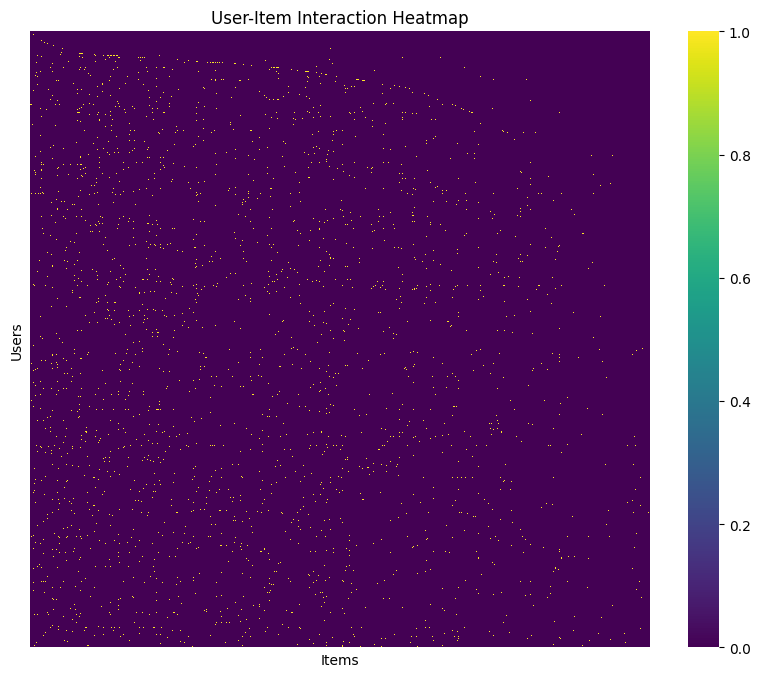

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_interaction_matrix' is your user-item interaction matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_interaction_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('User-Item Interaction Heatmap')
plt.xlabel('Items')
plt.ylabel('Users')
plt.show()

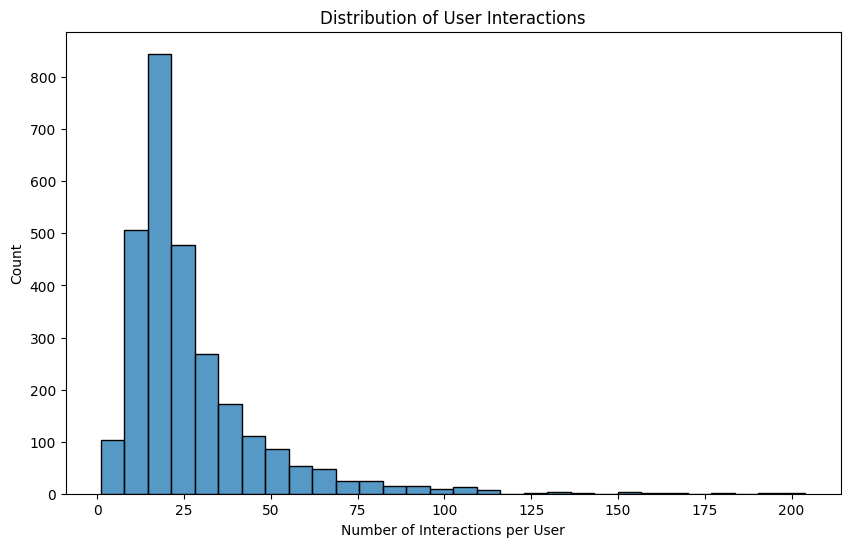

In [18]:
user_interactions_counts = np.sum(train_interaction_matrix, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(user_interactions_counts, bins=30, kde=False)
plt.title('Distribution of User Interactions')
plt.xlabel('Number of Interactions per User')
plt.ylabel('Count')
plt.show()


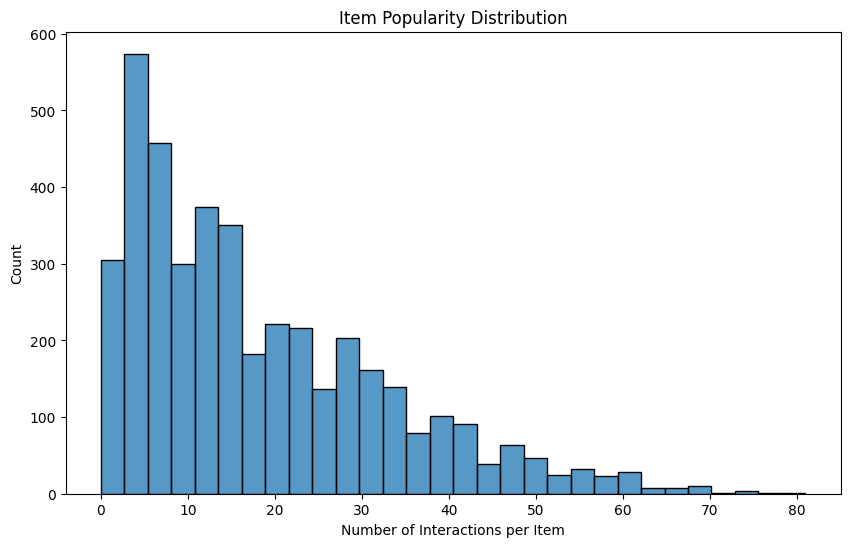

In [19]:
item_popularity_counts = np.sum(train_interaction_matrix, axis=0)
plt.figure(figsize=(10, 6))
sns.histplot(item_popularity_counts, bins=30, kde=False)
plt.title('Item Popularity Distribution')
plt.xlabel('Number of Interactions per Item')
plt.ylabel('Count')
plt.show()
